## Isolation Forest Model

Let's first start by loading the libraries we will be using.

In [31]:
import os
import sys
import copy
import time
import random
import pyspark
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from pyspark.sql.functions import col, substring


# for creating pipelines and model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import ParameterGrid
from pyspark.ml.linalg import Vectors
from pyspark_iforest.ml.iforest import *
from pyspark.sql import functions as F
from pyspark import SparkConf
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark_iforest.ml.iforest import IForest, IForestModel
from pyspark.ml.linalg import Vectors, VectorUDT
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

We initialize our spark session.

In [15]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()

Let's then load the preprocessed data after feature engineering and labelling.

In [38]:
feat_data = spark.read.parquet('../data/labeled_features3.parquet')
feat_data = feat_data.withColumn("age", feat_data.age.cast(DoubleType()))
feat_data = feat_data.withColumnRenamed("label_e", "label")
feat_data = feat_data.withColumn("model", substring("model", 6,1).cast(IntegerType()))

print(feat_data.count())

# highly imbalanced data
label_count_pd = feat_data.groupby('label').count().toPandas()
feat_data.limit(10).toPandas().head(10)

292142


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,...,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label
0,2016-01-01 01:00:00,155.926136,508.873216,103.217517,44.404096,168.808851,459.669547,103.067957,41.409164,169.366028,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
1,2015-12-31 22:00:00,177.241489,443.717507,103.011478,37.057737,174.314186,450.696569,100.441772,40.051142,169.556059,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
2,2015-12-31 19:00:00,170.262559,444.910532,107.530806,40.707467,170.484633,457.562043,100.751848,41.019130,166.773586,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-31 16:00:00,168.169328,453.981021,98.461255,43.418780,169.776971,456.909157,98.917461,40.899594,166.512359,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-31 13:00:00,181.583369,460.177215,92.763549,39.020584,170.272706,453.480797,98.386310,40.507900,167.148002,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-31 10:00:00,161.923275,471.179402,104.251783,40.929688,164.797932,446.889030,100.060783,41.448674,164.108382,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-31 07:00:00,167.431912,442.298992,100.193256,40.229322,163.062540,442.763560,99.445755,41.622275,163.607945,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-31 04:00:00,170.152267,440.267578,96.336650,41.852004,163.247748,445.304944,101.090962,42.385029,163.894898,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-31 01:00:00,159.684275,433.810148,99.461441,42.783680,164.023299,447.469174,102.041216,42.653336,165.401512,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-30 22:00:00,154.981705,454.677523,101.791672,41.624095,163.418831,448.430676,102.840632,42.795697,166.756664,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0


However, the data is very imbalanced. Most of the time there are no failures at all. We will tackle this by undersampling.

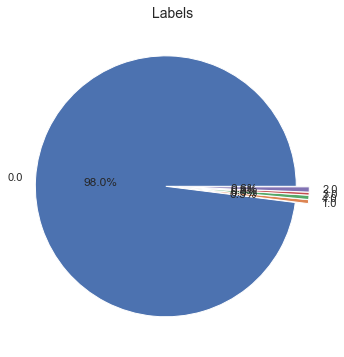

In [39]:
sns.set_theme(style="whitegrid")
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=label_count_pd['count'].tolist(), autopct="%.1f%%", explode=[0.05]*5, labels=label_count_pd['label'].tolist(), pctdistance=0.5)
plt.title("Labels", fontsize=14)
plt.show()

We remove some columns as input features.

In [17]:
label_var = ['label']
key_cols =['machineID','dt_truncated']
input_features = feat_data.columns
remove_cols = label_var + key_cols + ['failure','model_encoded']

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_cols)]
# Use cols
input_features

['volt_rollingmean_3',
 'rotate_rollingmean_3',
 'pressure_rollingmean_3',
 'vibration_rollingmean_3',
 'volt_rollingmean_12',
 'rotate_rollingmean_12',
 'pressure_rollingmean_12',
 'vibration_rollingmean_12',
 'volt_rollingmean_24',
 'vibration_rollingmean_24',
 'rotate_rollingmean_24',
 'pressure_rollingmean_24',
 'volt_rollingstd_3',
 'rotate_rollingstd_3',
 'pressure_rollingstd_3',
 'vibration_rollingstd_3',
 'volt_rollingstd_12',
 'rotate_rollingstd_12',
 'pressure_rollingstd_12',
 'vibration_rollingstd_12',
 'volt_rollingstd_24',
 'rotate_rollingstd_24',
 'pressure_rollingstd_24',
 'vibration_rollingstd_24',
 'error1sum_rollingmean_12',
 'error2sum_rollingmean_12',
 'error3sum_rollingmean_12',
 'error4sum_rollingmean_12',
 'error5sum_rollingmean_12',
 'comp1sum',
 'comp2sum',
 'comp3sum',
 'comp4sum',
 'model',
 'age']

### Train/ Test split

Here, we assemble the features to be used as input features and split the data into training and testing. The split will be 10 months for training and 2 months for testing.

We then undersample the labels as 0 so the model is less biased.

In [18]:
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
feat_data = va.transform(feat_data).select('machineID','dt_truncated','label','features')

feat_data = feat_data.withColumn("label", F.when(feat_data["label"] > 0, 1).otherwise(feat_data["label"]))

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(feat_data)

# split the data into train/test based on date
split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)

# Undersampling
training = training.sampleBy('label', fractions={0: 0.2, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}, seed=0)

print(training.count())
print(testing.count())

52257
50508


As we can see below, it is less imbalanced than before.

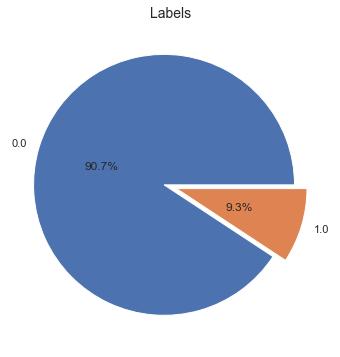

In [41]:
label_count_pd = training.groupby('label').count().toPandas()
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=label_count_pd['count'].tolist(), autopct="%.1f%%", explode=[0.05]*2, labels=label_count_pd['label'].tolist(), pctdistance=0.5)
plt.title("Labels", fontsize=14)
plt.show()

### Training

Here, we will then train the IF model make predictions. We use an open source library since it is not available right from pyspark. Link to library: [titicaca](https://github.com/titicaca/spark-iforest)

In [20]:
# conf = SparkConf()
# conf.set('spark.jars', '/opt/spark2.4.7/jars/spark-iforest-2.4.0.jar')

# spark = SparkSession \
#         .builder \
#         .config(conf=conf) \
#         .appName("IForestExample") \
#         .getOrCreate()

df = training

# scaler = StandardScaler(inputCol='vectorized_features', outputCol='scaled_features')
contamination_ratio = (1337 + 1473 + 1000 + 1862) / (1337 + 1473 + 1000 + 1862 + 67470 )

# clf = IsolationForest(contamination=contamination_ratio, max_features=1.0, random_state=0,
#                       n_estimators=500, bootstrap=True, warm_start=True)

iforest = IForest(contamination=contamination_ratio, numTrees=400, maxFeatures=1, maxSamples=8000, bootstrap=True)
iforest.setFeaturesCol('features')
iforest.setSeed(0)  # for reproducibility

# scaler_model = scaler.fit(df)
# df = scaler_model.transform(df)
model = iforest.fit(df, {'threshold': 0.5})

# Check if the model has summary or not, the newly trained model has the summary info
model.hasSummary

# Show model summary
summary = model.summary

# Show the number of anomalies
summary.numAnomalies

4052

In [21]:
# Predict for a new data frame based on the fitted model
predictions_rf = model.transform(testing)

predictions_rf.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  873|
|  0.0|       1.0| 5598|
|  1.0|       0.0|   72|
|  0.0|       0.0|43965|
+-----+----------+-----+



### Evaluation

We then evaluate the model with the following metrics

Area under ROC = 0.566637
Area under PR = 0.579637

Accuracy = 0.887741
Weighted Precision = 0.98221
Weighted Recall = 0.887741
F1 = 0.926252


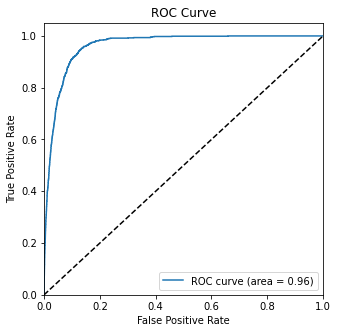

In [22]:
predictionAndLabels = predictions_rf.select("label", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('label','anomalyScore').toPandas()
labels = predictions_rf_pddf["label"]
prob = []
for dv in predictions_rf_pddf["anomalyScore"]:
    prob.append(dv)
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

As we can see, it performs way less well than RF or XGB. This was to be expected, since it is a binary classification algorithm. 


Having a closer look at each classes:

In [24]:
# Use sklearn
rf_result = predictions_rf.select('label', 'prediction').toPandas()

rf_label = rf_result['label'].tolist()
rf_prediction = rf_result['prediction'].tolist()

precision, recall, fscore, support = score(rf_label, rf_prediction)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99836501 0.1349096 ]
recall: [0.88705284 0.92380952]
fscore: [0.93942308 0.23543689]
support: [49563   945]


 Let's take a look at the confusion matrix.

In [28]:
cm = confusion_matrix(predictions_rf.select('label').collect(), predictions_rf.select('prediction').collect())

In [29]:
cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]

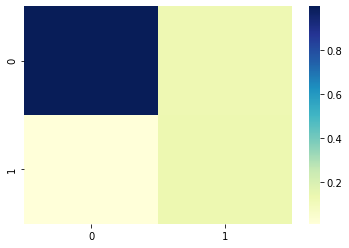

In [32]:
f = sns.heatmap(cm, cmap="YlGnBu")

Unfortunately, IF fails to predict the failures correctly.